In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from neuraldistributions.models import transforms

device = "cuda"

In [12]:
def subtract_min(arr):
    return arr - arr.min(0, keepdims=True)

In [13]:
flowfa_scan1 = torch.load("/project/models/flowfa_scan1")
flowfa_scan2 = torch.load("/project/models/flowfa_scan2")
ziffa_scan1 = torch.load("/project/models/ziffa_scan1")
ziffa_scan2 = torch.load("/project/models/ziffa_scan2")

In [14]:
sqrt = getattr(transforms, 'sqrt')(numpy=False).to(device)
anscombe = getattr(transforms, 'anscombe')(numpy=False).to(device)

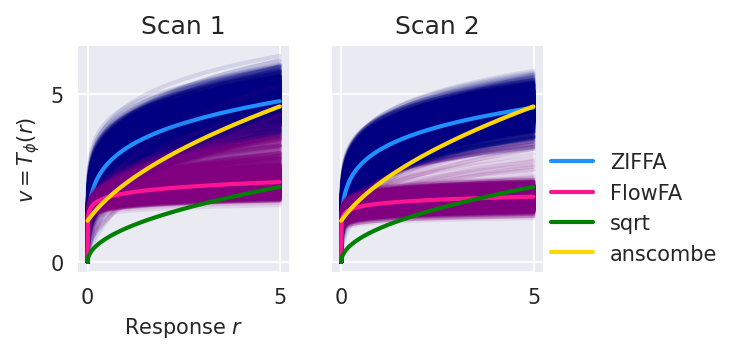

In [15]:
fig_name = f"Anscombe vs learned transformation"

y = torch.arange(0, 5, .01).to(device)[:, None] + 1.1e-7
out_sqrt = sqrt(y)[0].cpu().data.numpy()
out_anscombe = anscombe(y)[0].cpu().data.numpy()
out_ziffa1 = ziffa_scan1.sample_transform(y)[0].cpu().data.numpy()
out_ziffa2 = ziffa_scan2.sample_transform(y)[0].cpu().data.numpy()
out_flowfa1 = flowfa_scan1.sample_transform(y)[0].cpu().data.numpy()
out_flowfa2 = flowfa_scan2.sample_transform(y)[0].cpu().data.numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 2), dpi=150, sharex=True, sharey=True)

ax1.plot(y.cpu().data.numpy(), subtract_min(out_ziffa1), lw=2, c='navy', alpha=.1)
ax1.plot(y.cpu().data.numpy(), subtract_min(out_ziffa1).mean(1, keepdims=True), lw=2, c='dodgerblue', alpha=1) #, label="flow (scan 1)")
ax1.plot(y.cpu().data.numpy(), subtract_min(out_flowfa1), lw=2, c='purple', alpha=.1)
ax1.plot(y.cpu().data.numpy(), subtract_min(out_flowfa1).mean(1, keepdims=True), lw=2, c='deeppink', alpha=1)
ax1.plot(y.cpu().data.numpy(), out_sqrt, lw=2, c='green', label="sqrt")
ax1.plot(y.cpu().data.numpy(), out_anscombe, lw=2, c='gold', label="anscombe")

ax1.set(xlabel=r"Response $r$", ylabel=r"$v = T_\phi(r)$", title="Scan 1", xticks=[0, 5], yticks=[0, 5])

ax2.plot(y.cpu().data.numpy(), subtract_min(out_ziffa2), lw=2, c='navy', alpha=.1)
ax2.plot(y.cpu().data.numpy(), subtract_min(out_ziffa2).mean(1, keepdims=True), lw=2, c='dodgerblue', alpha=1, label="ZIFFA")
ax2.plot(y.cpu().data.numpy(), subtract_min(out_flowfa2), lw=2, c='purple', alpha=.1)
ax2.plot(y.cpu().data.numpy(), subtract_min(out_flowfa2).mean(1, keepdims=True), lw=2, c='deeppink', alpha=1, label="FlowFA")
ax2.plot(y.cpu().data.numpy(), out_sqrt, lw=2, c='green', label="sqrt")
ax2.plot(y.cpu().data.numpy(), out_anscombe, lw=2, c='gold', label="anscombe")

ax2.set(title="Scan 2")
ax2.legend(loc=(1., .0), ncol=1, frameon=False)

sns.despine(trim=True)

---

## Training the model on neural data (in case dataset is available)

In [8]:
import numpy as np
import torch

from neuraldistributions.datasets import mouse_static_loaders, extract_data_key
from neuraldistributions.models import poisson, zig, flowfa, ziffa
from neuraldistributions.trainers import base_trainer
from neuraldistributions.utility import get_loglikelihood

random_seed = 42
device = "cuda"

dataport not available, will only be able to load data locally


In [9]:
dataset_dir = "/project/data"
datasets = [
    "static23555-39-24-preproc0.zip",
    "static23549-4-8-GrayImageNet-7bed7f7379d99271be5d144e5e59a8e7.zip",
]
scan_id = [2, 1]
dataset_paths = [f"{dataset_dir}/{dataset}" for dataset in datasets]
areas = [["V1", "PM"], ["V1", "LM"]]
neurons_ns = [[1000, 1000], [1000, 907]]

In [10]:
dataset_index = 0
dataset_path = dataset_paths[dataset_index]
data_key = extract_data_key(dataset_path)
area = areas[dataset_index]
neurons_n = neurons_ns[dataset_index]

dataset_config = {
    "paths": [dataset_path],
    "seed": random_seed,
    "batch_size": 64,
    "area": area,
    "neurons_n": neurons_n,
    "normalize_images": True,
    "normalize_neurons": True,
    "return_more": True,
    "device": device,
    "shuffle_train": True,
}

dataloaders = mouse_static_loaders(**dataset_config)

FileNotFoundError: [Errno 2] No such file or directory: '/project/data/static23555-39-24-preproc0.zip'

## Image-computable model config

In [ ]:
grid_mean_pred_config = {
    "type": "cortex",
    "input_dimensions": 2,
    "hidden_layers": 4,
    "hidden_features": 20,
    "nonlinearity": "ReLU",
    "final_tanh": True,
}

image_model_config = {
    "pad_input": False,
    "stack": -1,
    "layers": 4,
    "input_kern": 15,
    "gamma_input": 1,
    "gamma_readout": 2.439,
    "hidden_dilation": 1,
    "hidden_kern": 13,
    "hidden_channels": 64,
    "n_se_blocks": 0,
    "depth_separable": True,
    "share_features": False,
    "share_grid": False,
    "init_sigma": 0.4,
    "init_mu_range": 0.55,
    "gauss_type": "full",
    "grid_mean_predictor": grid_mean_pred_config,
}

## ZIFFA

In [ ]:
model_name = "ziffa"
d_latent = 3
sample_transform = "learned2"
per_neuron_transform = True
unit_variance_constraint = True

model_config = {
    "image_model_fn": "neuraldistributions.models.controls.zif_fullgaussian2d",
    "image_model_config": image_model_config,
    "d_latent": d_latent,
    "sample_transform": sample_transform,
    "per_neuron_samples_transform": per_neuron_transform,
    "zero_threshold": 1.1e-7,
    "init_psi_diag_coef": 0.1,
    "init_C_coef": 0.1,
    "unit_variance_constraint": unit_variance_constraint,
}

model = ziffa(dataloaders, random_seed, **model_config)

## FixedFA

In [ ]:
d_latent = 3
sample_transform = "sqrt" # options: identity, sqrt, anscombe
mean_transform = "learned"
per_neuron_transform = False
unit_variance_constraints = False

model_config = {
    "image_model_fn": "nnsysident.models.models.se2d_fullgaussian2d",
    "image_model_config": image_model_config,
    "d_latent": d_latent,
    "sample_transform": sample_transform,
    "mean_transform": mean_transform,
    "per_neuron_samples_transform": per_neuron_transform,
    "init_psi_diag_coef": 0.1,
    "init_C_coef": 0.1,
    "unit_variance_constraint": unit_variance_constraint,
}

model = flowfa(dataloaders, random_seed, **model_config)

## FlowFA

In [ ]:
model_name = "flowfa"
d_latent = 3
sample_transform = "learned2"
mean_transform = "learned"
per_neuron_transform = True
unit_variance_constraint = False

model_config = {
    "image_model_fn": "nnsysident.models.models.se2d_fullgaussian2d",
    "image_model_config": image_model_config,
    "d_latent": d_latent,
    "sample_transform": sample_transform,
    "mean_transform": mean_transform,
    "per_neuron_samples_transform": per_neuron_transform,
    "init_psi_diag_coef": 0.1,
    "init_C_coef": 0.1,
    "unit_variance_constraint": unit_variance_constraint,
}

model = flowfa(dataloaders, random_seed, **model_config)

## ZIG

In [ ]:
from copy import deepcopy
zig_image_model_config = deepcopy(image_model_config)
zig_image_model_config["zero_thresholds"] = {data_key: 1.1e-7}

In [ ]:
model_config = {
    "image_model_fn": "neuralmetrics.models.neuralnet.model_functions.zig_se2d_fullgaussian2d",
    "image_model_config": zig_image_model_config,
}

model = zig(dataloaders, random_seed, **model_config)

## Poisson

In [ ]:
model_config = {
    "image_model_fn": "nnsysident.models.models.se2d_fullgaussian2d",
    "image_model_config": image_model_config,
}

model = poisson(dataloaders, random_seed, **model_config)

## Train the model

In [ ]:
trainer_config = {
    "epochs": 1000,
    "device": "cuda",
    "lr": 0.005,
}

## The following line would train the model (upon availability of the dataset)
# out = base_trainer(model, dataloaders, random_seed, **trainer_config)

In [ ]:
filename = "/project/models/" + f"{model_name}_scan{scan_id[dataset_index]}"
filename

In [ ]:
# torch.save(model, filename)

### Log-likelihood (in bits per neuron per image)

In [ ]:
n_neurons = len(dataloaders['test'][data_key].dataset.neurons.ids)
n_images = len(dataloaders['test'][data_key].dataset.trial_info.image_ids)

In [ ]:
get_loglikelihood(dataloaders["test"], model)[1][0] / np.log(2) / n_neurons / n_images

---